# ベイズ統計学最終課題

2019年慶應義塾大学SFCベイズ統計学最終課題のJupyter Notebook。
気象データとGoogle Trendsデータを用いてインフルエンザの流行予測を行う。

## 目次
* [1. データの概要](#data_intro)
* [2. 探索的データ分析](#explore)
    * [2.1 インフルエンザ定点報告数の分布](#influenza_distribution)
    * [2.2 説明変数: 東京の平均気温](#tokyo_avg_temp)
    * [2.3 説明変数: 相対湿度と絶対湿度](#humidity)
    * [2.4 説明変数: Google Trends](#google)
    * [2.5 まとめ](#exp_sum)
* [3. データの準備](#data_prep)
    * [3.1 対数化](#log_prep)
    * [3.2 標準化](#norm_prep)
* [4. インフルエンザとの相関](#inf_corr)
    * [4.1 相関表](#correlogram)
    * [4.1 相関に基づいた変数選択](#var_sel)
* [5. ベンチマークの設定](#bench)
    * [5.1 評価関数](#metrics)
    * [5.2 ベースライン](#baseline)
    * [5.3 スタンダード機械学習モデル](#ml)

### 使用ライブラリー

In [1]:
#データ編集用にnumpyとpandas
import numpy as np
import pandas as pd
np.random.seed(42) #ランダムシードを固定

#可視化用にmatplotlibとseaborn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
import seaborn as sns

#Scipyヘルパー関数
from scipy.stats import percentileofscore
from scipy import stats

In [2]:
#比較用のスタンダードの機械学習モデル
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

#学習用、テスト用データのスプリット
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#Na値の対応
from sklearn.impute import SimpleImputer

#Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

#分布
import scipy

In [3]:
#ベイズ推定用
import pymc3 as pm

### データのインポート 

In [4]:
inf_df = pd.read_excel('./data/influenza.xlsx')
print('=== Imported Data ===')

=== Imported Data ===


## 1. データの概要 <a class="anchor" id="data_intro"></a>
<p>このデータセットは2013年40週から2019年20週までの東京都インフルエンザ定点報告数及び気象データをまとめたものである。インフルエンザ定点報告数は主に厚生労働省のホームページから取得したが、データがない期間が存在したため、東京感染症情報センターより取得したデータで補足を行なった。データは全て報告書形式でpdfファイルとして保存されていたため、データの入力は全て手作業で行なった。気象データは気象庁のホームページより取得したものである。</p>
<ol>
    <li>厚生労働省インフルエンザ定点報告: https://www.mhlw.go.jp/stf/seisakunitsuite/bunya/kenkou_iryou/kenkou/kekkaku-kansenshou01/houdou.html
    <li>東京感染症情報センター: http://idsc.tokyo-eiken.go.jp/weekly/
    <li>気象庁ホームページ: https://www.data.jma.go.jp/obd/stats/etrn/index.php
</ol>

<p>このデータには合計302つのデータ点と10つの項目がある。それぞれの項目名と内容は以下の通りである。</p>
<ul>
    <li>week: 2013年40週(2013年9月30日)〜2019年(2019年5月19日)までの週情報</li>
    <li>inf_pts: 東京都のインフルエンザ定点報告数(医療機関あたりの患者数)</li>
    <li>temp: 東京都の一週間の平均気温(C)</li>
    <li>temp_range: 最高気温と最低気温の差</li>
    <li>rain: 一週間の合計降水量(mm)</li>
    <li>humidity: 一週間の平均相対湿度(％)</li>
    <li>tokyo_cloud: 一週間の平均雲量(10分比)</li>
    <li>sunlight: 平均全天日射量(MJ/㎡)</li>
    <li>wind: 平均風速(m/s)</li>
    <li>google: Google Trendsより取得した「インフルエンザ」の検索トレンド(相対データ、無単位)</li>
</ul>

In [5]:
inf_df = inf_df.dropna() #NA値を排除
inf_df.head()

,week,inf_pts,temp,temp_range,rain,humidity,cloud,sunlight,wind,google
61,2014年49週,5.86,7.7,-0.8,5.0,52.0,3.4,8.76,2.4,153.75
62,2014年50週,10.15,7.2,1.0,1.5,53.0,5.1,8.47,2.6,150.88
63,2014年51週,20.60,5.5,-2.6,39.0,56.0,4.2,8.51,2.9,182.45
64,2014年52週,32.90,5.2,-3.3,5.5,52.0,4.1,8.63,2.5,259.53
65,2015年1週,11.05,5.1,-2.3,0.0,53.0,2.8,9.22,2.5,252.46


In [6]:
print('行数: {}、列数: {}'.format(inf_df.shape[0], inf_df.shape[1]))

行数: 234、列数: 10


In [7]:
inf_df.describe()

,inf_pts,temp,temp_range,rain,humidity,cloud,sunlight,wind,google
count,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000,234.000000
mean,6.101368,15.759829,8.798718,29.337607,67.551282,6.699145,13.335812,2.871795,76.546496
std,11.544633,7.671961,7.472889,41.595453,12.100772,2.027557,4.697020,0.549576,97.969083
min,0.000000,2.100000,-5.400000,0.000000,40.000000,1.500000,4.860000,2.000000,2.390000
25%,0.100000,8.275000,2.225000,2.500000,59.000000,5.300000,9.707500,2.500000,8.810000
50%,0.590000,15.950000,9.100000,15.500000,68.000000,6.900000,12.320000,2.800000,33.965000
75%,6.300000,21.900000,14.875000,39.750000,77.000000,8.400000,16.680000,3.200000,121.940000
max,64.180000,30.600000,23.800000,307.500000,94.000000,10.000000,25.770000,5.400000,607.000000


## 2. 探索的データ分析 <a class="anchor" id="explore"></a>
<p>事前調査より、インフルエンザの流行は気温と湿度に大きく関わることがわかった。インフルエンザウイルスは飛沫感染をするタイプのウイルスで低温低湿度の環境で長く生き残る。さらに、ネットが普及している今、Googleでの「インフルエンザ」の検索数もインフルエンザの流行を予測する上で有効な指数となってくる。したがって、探索的データ分析においては、目的変数であるインフルエンザ定点報告数と説明変数である気温、湿度、Google Trendsを取り上げていく。</p>

### 2.1 インフルエンザ定点報告数の分布 <a class="anchor" id="influenza_distribution"></a>

In [8]:
#Decorations
def decorate_plot(xlabel=None, ylabel=None, title=None):
    plt.gca().spines['top'].set_alpha(.3)
    plt.gca().spines['bottom'].set_alpha(.3)
    plt.gca().spines['left'].set_alpha(.3)
    plt.gca().spines['right'].set_alpha(.3)
    plt.grid(linestyle='--', alpha=.5)
    if xlabel:
        plt.xlabel(xlabel, fontsize=10)
    if ylabel:
        plt.ylabel(ylabel, fontsize=10)
    if title:
        plt.title(title, fontsize=12)

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


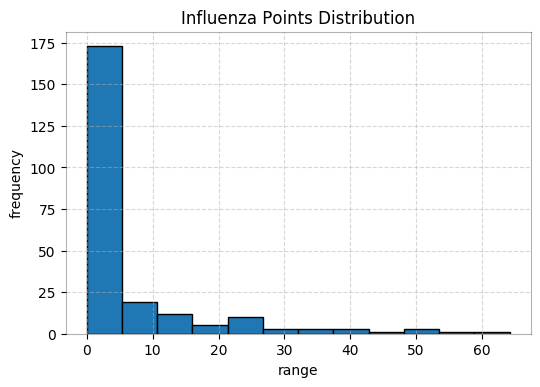

In [9]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(inf_df.inf_pts, bins=12, edgecolor='k')
decorate_plot('range', 'frequency', 'Influenza Points Distribution')
plt.show()

<p>インフルエンザ定点報告数の最大値は64.18、最小値は0、平均値は5.73、中央値が0.435である。歪度と尖度がそれぞれ2.58と6.7であることから分布がかなり右に歪んでいて、鋭いことがわかる。このことはチャートからも確認できる。一年を通してインフルエンザが流行る時期はそこまで長くないためこのような分布になる。</p>

### 2.2 説明変数: 東京の平均気温 <a class="anchor" id="tokyo_avg_temp"></a>

In [10]:
inf_df.temp.describe()

count    234.000000
mean      15.759829
std        7.671961
min        2.100000
25%        8.275000
50%       15.950000
75%       21.900000
max       30.600000
Name: temp, dtype: float64

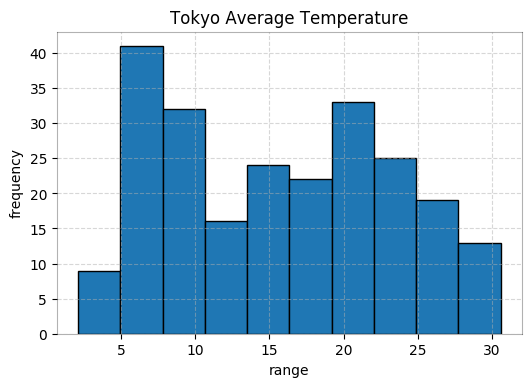

In [11]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(inf_df.temp, bins=10, edgecolor='k')
decorate_plot('range', 'frequency', 'Tokyo Average Temperature')
plt.show()

<p>東京の平均温度の最小値は2.1、最大値は30、平均値は15.9、そして標準偏差は7.6である。標準分布に近いものになると予想していたが、チャートからピークが二つある部分布になっていることがわかる。インフルエンザ定点報告数はその週に医療機関から報告された患者数に基づいて計算されている。しかし、インフルエンザには1~3日間の潜伏期間がある上、症状が現れて患者が病院に訪れるまで時間がかかるのでその週の気温より、一週間前から二週間前の気温の方が影響があると予想される。よって、分析では気温を一週間と二週間前にずらしたものも利用する。</p>

In [12]:
def shift_week_front(data: list):
    """データを1週間と2週間分前にシフトする
    
    data: シフトしたいデータ
    
    Returns: 一週間前にシフトしたデータ, 二週間前にシフトしたデータ
    """
    
    data = np.asarray(data)
    shift_w1 = np.insert(data, 0, None)[:-1]
    shift_w2 = np.insert(shift_w1, 0, None)[:-1]
    return shift_w1, shift_w2

inf_df['temp_w1'], inf_df['temp_w2'] = shift_week_front(inf_df.temp)

### 2.3 説明変数: 相対湿度と絶対湿度 <a class="anchor" id="humidity"></a>

In [13]:
inf_df.humidity.describe()

count    234.000000
mean      67.551282
std       12.100772
min       40.000000
25%       59.000000
50%       68.000000
75%       77.000000
max       94.000000
Name: humidity, dtype: float64

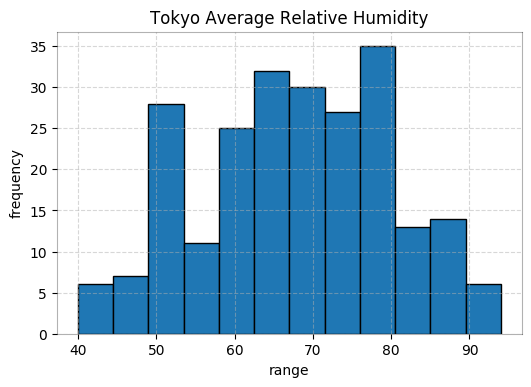

In [14]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(inf_df.humidity, bins=12, edgecolor='k')
decorate_plot('range', 'frequency', 'Tokyo Average Relative Humidity')
plt.show()

<p>東京都の相対湿度の最小値は40%、最大値は94%、平均値は68%、標準偏差は12.25である。チャートから読み取れるように、ベル型分布となっている。</p>
<ul>
    <li>相対湿度: ある温度の空気中に含みうる最大限の水分量（飽和水蒸気量）に比べて、どの程度の水分を含んでいるかを示す値で表す。</li>
    <li>絶対湿度: 湿り空気（一般に存在する空気）中の乾き空気（全て水分を含まない空気）1kgに対する水蒸気の重量割合を示す。</li>
</ul>
<p>インフルエンザ予測において相対湿度より絶対湿度が良いと考えられる。インフルエンザ飛沫感染型のウイルスで乾燥した空気の方が生存しやすいため空気中の水蒸気量が予測において大切だが、相対湿度は空気中の実際の水蒸気量を表していないので適していないと考えられる。よって、相対湿度から絶対湿度への変換を行う必要がある。</p>

In [15]:
#相対湿度から絶対湿度へ変換
def rel_to_abs_humidity(temp: list, rel_humid: list):
    """相対湿度を絶対湿度に変換する

    temp: 気温の配列
    
    rel_humid: 相対湿度の配列
    
    Returns: 絶対湿度の配列
    """
    e = 6.1078*np.power(10, 7.5*temp/(temp + 237.3)) #飽和水蒸気圧の計算
    a = 217*e / (temp + 273.15) #飽和水蒸気量の計算
    VH = a * rel_humid / 100 #絶対湿度の計算
    return VH

inf_df['abs_humid'] = rel_to_abs_humidity(inf_df.temp, inf_df.humidity)

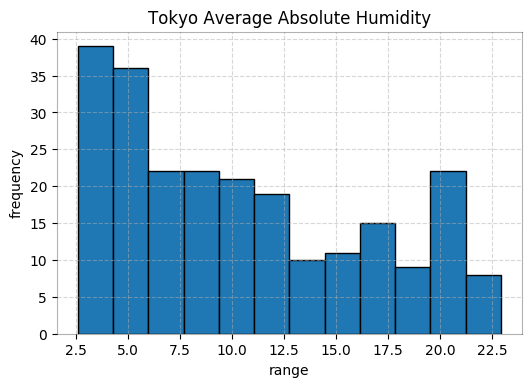

In [16]:
plt.figure(figsize=(6,4), dpi=100)
plt.hist(inf_df.abs_humid.dropna(), bins=12, edgecolor='k')
decorate_plot('range', 'frequency', 'Tokyo Average Absolute Humidity')
plt.show()

<p>このチャートは東京都の絶対湿度の分布を表している。相対湿度の分布と比べて指数的な分布になっていることがわかる。これは絶対湿度の計算が気温を変数にする指数関数であるからだと考えられる。また気温と同様に1週間前、2週間前にずらしてものも用意する。それに加え相対湿度をデータから除外する</p>

In [17]:
inf_df['humid_w1'], inf_df['humid_w2'] = shift_week_front(inf_df.abs_humid)
inf_df = inf_df.drop(columns=['humidity'])

### 2.4 説明変数: Google Trends <a class="anchor" id="google"></a>
<p>日本ではインターネット及びインターンネット接続端末の普及が進んでいるため、近年の情報収集はネットで行われるようになっている。冬に熱を出した時、人は病院に行く前にまずネットでインフルエンザの症状を調べて自分がインフルエンザにかかっているかどうか自己診断することが多いと考えたため、Google Trendsのデータを利用することでインフルエンザの予測ができるのではないかと考えた。</p>
<p>Google Trendsのデータは指定する期間によってデータの感覚が異なってくる。例えば一年以上をデータ取得期間と設定すると一ヶ月毎のデータがくる。一方一ヶ月や二ヶ月など短い期間であれば1日毎のデータがくる。問題はGoogle Trends上のデータは標準化されていて、指定期間の間で0~100値をとるように設定されている。その期間の最大値は必ず100となり、そのほかのデータはその最大値を元に計算された相対的な指数である。最大値がわからないため、非標準化が難しい。</p>
<p>この分析の目的は相関を調べることであるため、相対的なデータでも問題はない。しかし、先ほども言ったように取得期間によってデータの間隔が異なり、さらにそれぞれにおいて0~100までの範囲で一般化されているため、工夫をしなければ利用できない。そこで、打開策としてまず今回調べたい期間の一ヶ月ごとを取得することで1日毎のデータを取得し、繋げ合わせる。次に調べたい期間の全体のデータを取得することで月毎のデータを取得する。月毎のデータを対応する日データに重りとしてかけることによって標準化の問題を乗り越えることができる。</p>

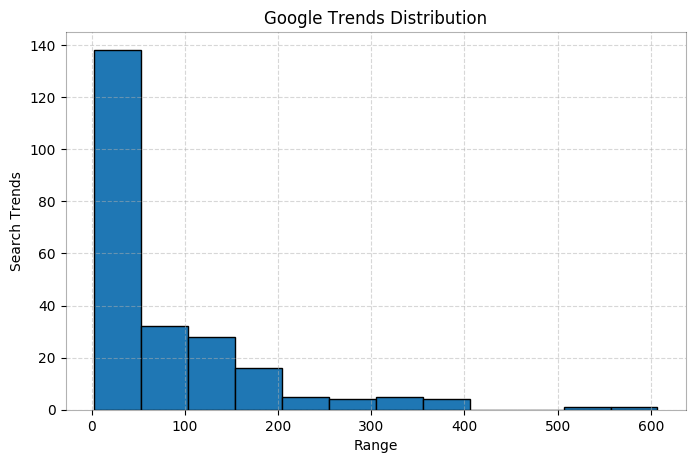

In [18]:
plt.figure(figsize=(8, 5), dpi=100)
plt.hist(inf_df.google, bins=12, edgecolor='k')
decorate_plot('Range', 'Search Trends', 'Google Trends Distribution')
plt.show()

Google検索の分布はインフルエンザ定点報告数の分布と似ていることがチャートからわかる。

### 2.5 まとめ <a class="anchor" id="exp_sum"></a>

In [19]:
def Normalize(dataframe):
    """データフレームを標準化する関数
    dataframe: データフレームを受け取る
    
    Returns: Dataframe
    """ 
    for column in dataframe.columns:
        mean = dataframe[column].mean() #平均値
        std = dataframe[column].std() #標準偏差
        dataframe[column] = (dataframe[column] - mean) / std
    return dataframe

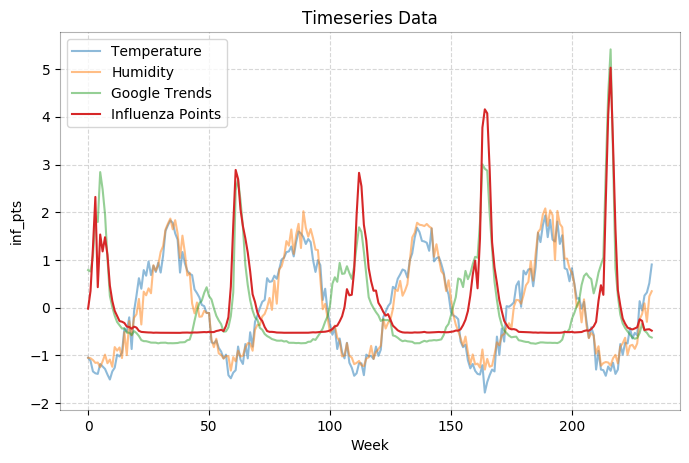

In [20]:
temp_df = inf_df.copy()
temp_df = Normalize(temp_df.drop(columns=['week']))
temp_df['arange'] = np.arange(len(inf_df))
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(x='arange', y='temp', data=temp_df, label='Temperature', alpha=.5) #気温
sns.lineplot(x='arange', y='abs_humid', data=temp_df, label='Humidity', alpha=.5) #湿度
sns.lineplot(x='arange', y='google', data=temp_df, label='Google Trends', alpha=.5) #Google
sns.lineplot(x='arange', y='inf_pts', data=temp_df, label='Influenza Points')
decorate_plot('Week', '', 'Timeseries Data')
plt.show()

<p>このチャートは標準化した気温、湿度、Google Trends、そしてインフルエンザ定点報告数の時系列推移である。まず、Google Trendsとインフルエンザ定点報告数のピークが一致していることから、この二つの変数の間には強い正の相関があると考えられる。次に気温と湿度の谷がインフルエンザ定点報告数のピークに来ていることがわかる。これはインフルエンザが寒く乾燥して時期において流行しやすいという事前調査の情報を裏付けする形になっている。</p>

## 3. データの準備 <a class="anchor" id="data_prep"></a>
<p>回帰分析を始める前に、データをもう少し整える必要がある。具体的には対数化と標準化の二段階のステップを踏む必要がある。</p>

In [21]:
df = inf_df.copy() #この先かなりデータ編集をするので、元のデータと別に編集するためコピーをする。
df.head()

,week,inf_pts,temp,temp_range,rain,cloud,sunlight,wind,google,temp_w1,temp_w2,abs_humid,humid_w1,humid_w2
61,2014年49週,5.86,7.7,-0.8,5.0,3.4,8.76,2.4,153.75,NaN,NaN,4.222676,NaN,NaN
62,2014年50週,10.15,7.2,1.0,1.5,5.1,8.47,2.6,150.88,7.7,NaN,4.166571,4.222676,NaN
63,2014年51週,20.60,5.5,-2.6,39.0,4.2,8.51,2.9,182.45,7.2,7.7,3.938823,4.166571,4.222676
64,2014年52週,32.90,5.2,-3.3,5.5,4.1,8.63,2.5,259.53,5.5,7.2,3.585762,3.938823,4.166571
65,2015年1週,11.05,5.1,-2.3,0.0,2.8,9.22,2.5,252.46,5.2,5.5,3.630632,3.585762,3.938823


### 3.1 対数化 <a class="anchor" id="log_prep"></a>
<p>探索的データ分析でインフルエンザ定点報告数の分布を見た時、かなり左に歪んだ分布だということがわかった。0付近に多くの点が集まっていて、このままでは回帰分析が難しいことがわかっている。そのため、対数をとることによって分布を少し広げる必要がある。これに伴いほかの変数も対数化する。</p>

In [22]:
df = df.drop(columns=['week'])
for col in df.columns:
    df[col] = np.log(df[col] + 0.01) #eを底に対数化する。また無限にならないよう小さい値を足しておく。

### 3.2 標準化 <a class="anchor" id="norm_prep"></a>
<p>この段階ではデータのそれぞれの項目が違うスケール上にあり、取りうる値の範囲も大きく異なるため、比較するのが難しい。したがって、標準化することにより、比較を行いやすくする。標準化は先ほど定義した標準化関数を利用する</p>

In [23]:
df = Normalize(df)

## 4. インフルエンザとの相関 <a class='anchor' id='inf_corr'></a>

### 4.3 相関表 <a class='anchor' id="correlogram"></a>

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


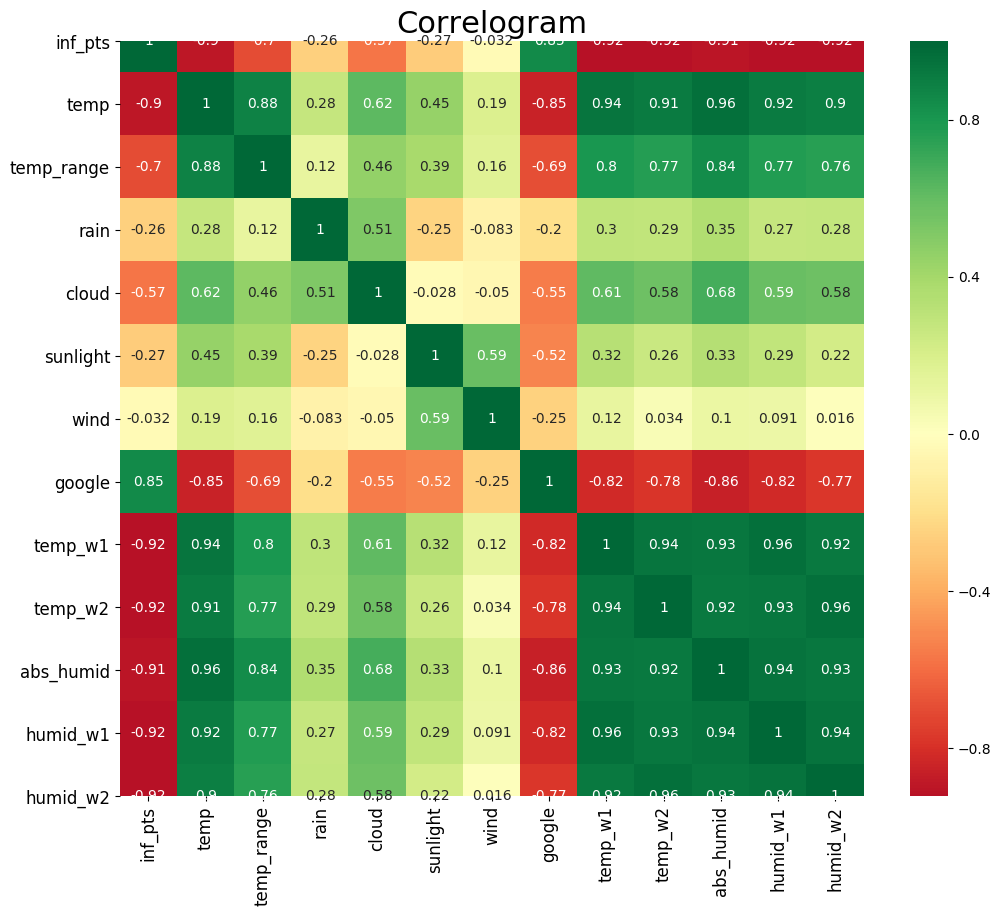

In [24]:
# Plot
plt.figure(figsize=(12,10), dpi= 100)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

このチャートはデータフレームの各変数の相関表である。色が濃いほど相関が強いことを表していて、赤が負の相関、緑が正の相関である。注目するべきは一行目のインフルエンザ定点数が他の変数間の相関である。先ず探索的データ分析でも予想したように、気温、湿度、Google検索と非常に強い相関を見せている。また、温度差と雲の量とも中程度の負の相関がある。一方降水量、日射量、平均風速とは全く相関がないことが読み取れる。

### 4.2 相関に基づいた変数選択 <a class='anchor' id='var_sel'></a>

<p>この段階では変数が多すぎるので、相関の強さを尺度にして、最もインフルエンザ予測にとって重要だと思われる変数を7つ選択する。</p>

In [25]:
# Takes in a dataframe, finds the most correlated variables with the
# grade and returns training and testing datasets
def format_data(df, target, num = 7, test=0.25):
    """データフレームを受け取り、相関が最も強い変数を特定する。
    その後、学習用とテスト用にデータを分割する。
    
    target: 目標変数
    
    num: 最終的に残したい変数の数。デフォルトは6。
    
    test: テストデータの大きさ。デフォルトは0.25。
    
    Returns: X_train, X_test, y_train, y_test
    """
    
    labels = df[target]
    
    # Find correlations with the Grade
    most_correlated = df.corr().abs()[target].sort_values(ascending=False)
    
    # Maintain the top 6 most correlation features
    most_correlated = most_correlated[:num+1]
    
    df = df.loc[:, most_correlated.index]

    
    # Split into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, labels, 
                                                        test_size = 0.25,
                                                        random_state=42)
    
    return X_train, X_test, y_train, y_test

In [26]:
X_train, X_test, y_train, y_test = format_data(df, 'inf_pts')
X_train.head()

,inf_pts,temp_w2,humid_w2,temp_w1,humid_w1,abs_humid,temp,google
165,0.551426,-0.143147,-0.100280,-0.697586,-0.431200,-0.538816,-0.404062,1.153179
233,0.570935,-0.874579,-0.680144,-0.160060,-0.371860,-0.331048,-0.486446,-0.054685
232,0.824913,-0.349257,-0.580041,-0.878459,-0.683387,-0.374877,-0.163941,0.169413
172,1.550219,-1.387629,-1.185736,-1.808137,-1.539553,-1.469255,-1.673795,1.284983
282,0.644887,-1.475062,-1.492521,-0.551226,-0.733996,-0.617243,-0.882664,0.222681


ここでの問題として、気温の変数が三つ、湿度の変数が三つあることである。データを準備する段階で、一週間と二週間ずらした気温と湿度が全て含まれている。相関表を見ると、予想通りに胃週間前倒しした気温と湿度の方がインフルエンザと高い相関を示していて(0.1しか差はないが)、変数をさらに絞り込むために、ずらす前の気温と湿度を除外する。

In [27]:
X_train, X_test = X_train.drop(columns=['temp', 'abs_humid']), X_test.drop(columns=['temp', 'abs_humid'])

In [28]:
print(X_train.shape)
print(X_test.shape)

(175, 6)
(59, 6)


## 5. ベンチマークの設定 <a class="anchor" id="bench"></a>

### 5.1 評価関数 <a class="anchor" id="metrics"></a>
<p>この回帰分析ではモデルの精度を評価するため二つの評価関数を利用する。</p>
<ul>
    <li>Mean Absolute Error(MAE): 予測値と実測値の差の絶対値の平均値。</li>
    <li>Root Mean Squared Error(RMSE): 予測値と実測値差の二乗の平方根の平均値。</li>
</ul>
<p>MAEはより直感的に理解しやすいが、RMSEの方が大きな誤差を厳しく評価してくれる。</p>

In [29]:
def evaluate_predictions(predictions, true):
    mae = mean_absolute_error(true, predictions)
    rmse = np.sqrt(mean_squared_error(true, predictions))
    
    return mae, rmse

### 5.2 ナイーブベースライン <a class="anchor" id="baseline"></a>
<p>モデルの精度を客観的に評価する上で、基準となるベースラインを設定する必要がある。今回はインフルエンザ定点報告数の中央値を利用してナイーブ(中央値と実測値と差の平均)なベースラインを設定する。</p>

In [30]:
median_pred = y_test.median()
median_preds = [median_pred for _ in range(len(X_test.drop(columns=['inf_pts'])))]
true = y_test

In [31]:
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 0.7866
Median Baseline RMSE: 0.9267


MAEのベースラインは0.7866、RMSEのベースラインは0.9267である。これから構築するモデルはこの数値を下回ることが目標となる。

### 5.3 スタンダード機械学習モデル <a class="anchor" id="ml"></a>
<p>ナイーブベースラインのみならず、他のモデルとの比較を行うことも大切である。ここではスタンダードの機械学習アルゴリズムを比較対象として用意する: </p>
<ul>
    <li>Linear Regressor</li>
    <li>Elastic Net Regressor</li>
    <li>Random Forest Regressor</li>
    <li>Extra Trees Regressor</li>
    <li>Support Vector Regressor</li>
</ul>

In [32]:
def evaluate(X_train, X_test, y_train, y_test):
    """いくつかの機械学習モデルを評価する。
    """
    #モデル名
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    #インスタンス化
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    #結果を格納するDataFrame
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    X_train = X_train.drop(columns=['inf_pts'])
    X_test = X_test.drop(columns=['inf_pts'])
    
    #NA値対応
    imputer = SimpleImputer()
    X_train = imputer.fit_transform(X_train)
    
    #学習して予測を行う
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        #評価
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        #DFに結果を挿入
        model_name = model_name_list[i]
        results.loc[model_name, :] = [mae, rmse]
    
    #評価関数で評価
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.loc['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [33]:
results = evaluate(X_train, X_test, y_train, y_test)

#### 可視化して比較する

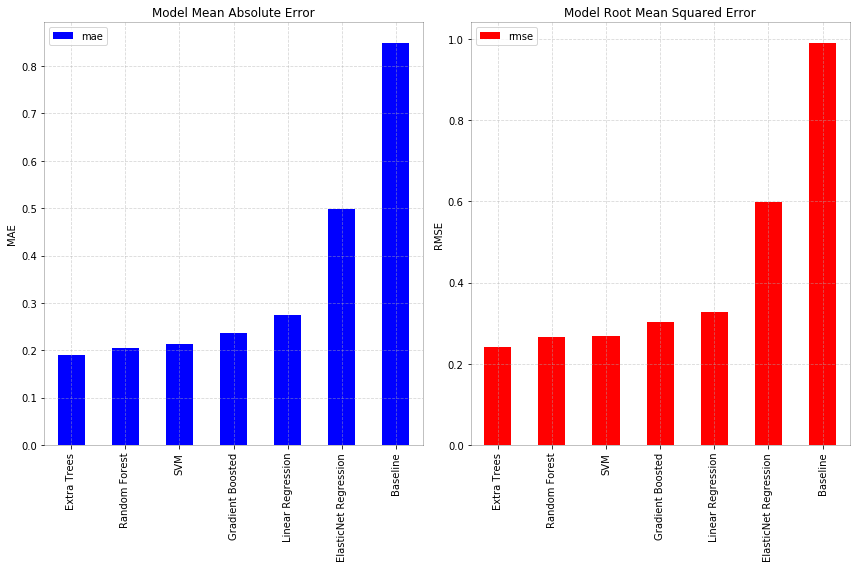

In [34]:
plt.figure(figsize=(12, 8))
# Root mean squared error
ax =  plt.subplot(1, 2, 1)
results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'b', ax = ax)
decorate_plot()
plt.title('Model Mean Absolute Error'); plt.ylabel('MAE');

# Median absolute percentage error
ax = plt.subplot(1, 2, 2)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'r', ax = ax)
decorate_plot()
plt.title('Model Root Mean Squared Error'); plt.ylabel('RMSE');

plt.tight_layout()

In [35]:
results.sort_values(by='mae')

,mae,rmse
Extra Trees,0.190917,0.241776
Random Forest,0.203898,0.265387
SVM,0.213961,0.269012
Gradient Boosted,0.237296,0.30428
Linear Regression,0.273938,0.32653
ElasticNet Regression,0.499299,0.598888
Baseline,0.849795,0.991545


In [36]:
print('Extra Tress RegressorはBaselineより{:0.2f}%優れている'.format(
    (100 * abs(results.loc['Extra Trees', 'mae'] - results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

Extra Tress RegressorはBaselineより77.53%優れている


### 5.4 一般的な線形回帰モデルの構築

In [37]:
lr = LinearRegression()

imputer = SimpleImputer()
X_t = imputer.fit_transform(X_train.drop(columns=['inf_pts']))

lr.fit(X_t, y_train)

ols_formula = 'inf_pts = %0.2f +' % lr.intercept_
for i, col in enumerate(X_train.columns[1:]):
    ols_formula += ' %0.2f * %s +' % (lr.coef_[i], col)
    
' '.join(ols_formula.split(' ')[:-1])

'inf_pts = -0.01 + -0.20 * temp_w2 + -0.25 * humid_w2 + -0.23 * temp_w1 + -0.09 * humid_w1 + 0.24 * google'

## 6. 線形回帰モデルのベイズ推定 <a class="anchor" id="bayes"></a>

### 6.1 仮説 <a class="anchor" id="hypothesis"></a>
<p>探索的データ分析及び相関係数の分析の結果を元に、インフルエンザ定点報告数はtemp_w2、temp_w1、humid_w1、humid_w2、そしてgoogleと相関があると仮定する。以下のRスタイルの式はこれらの変数がインフルエンザ定点報告数と線形的な関係にあるころとを意味している。</p>

In [38]:
# Formula for Bayesian Linear Regression
formula = 'inf_pts ~ ' + ' + '.join(['%s' % variable for variable in X_train.columns[1:]])
formula

'inf_pts ~ temp_w2 + humid_w2 + temp_w1 + humid_w1 + google'

### 6.2 PyMC3でモデル構築し事後分布からサンプリングする
この仮定を元に、PyMC3ライブラリーを用いて事前分布を構築し、Markov Chain Monte Carlo法で事後分布からサンプリングを行い、ベイズ推定を行うことができる。

In [104]:
# Context for the model
with pm.Model() as normal_model:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=2000, chains = 2, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, google, humid_w1, temp_w1, humid_w2, temp_w2, Intercept]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:12<00:00, 474.17draws/s]


In [105]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(14, len(trace.varnames)*1.8),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    matplotlib.rcParams['font.size'] = 16
    
    # Labels with the median value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (-18, 18), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')

/Users/shozendan/Downloads/Bayes_Statistics/env/lib/python3.6/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


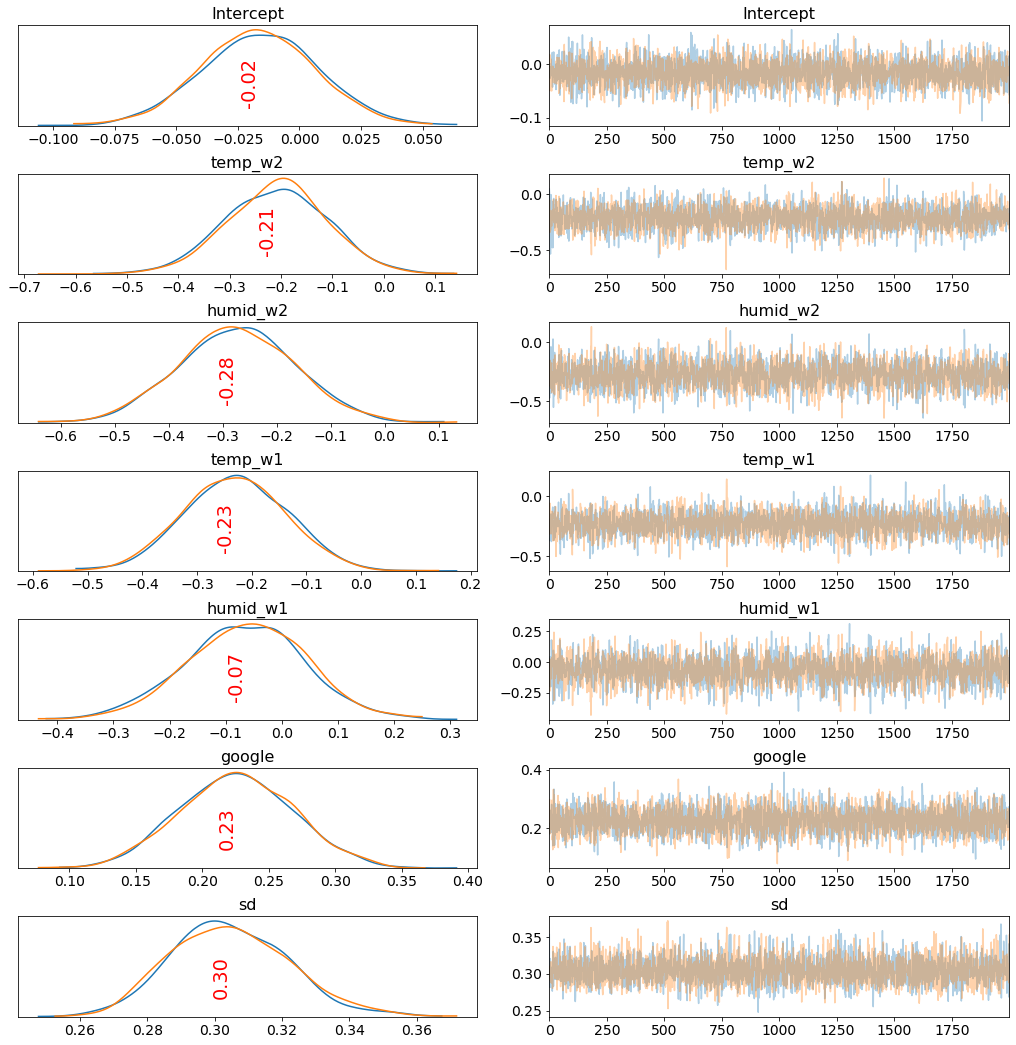

In [106]:
plot_trace(normal_trace);

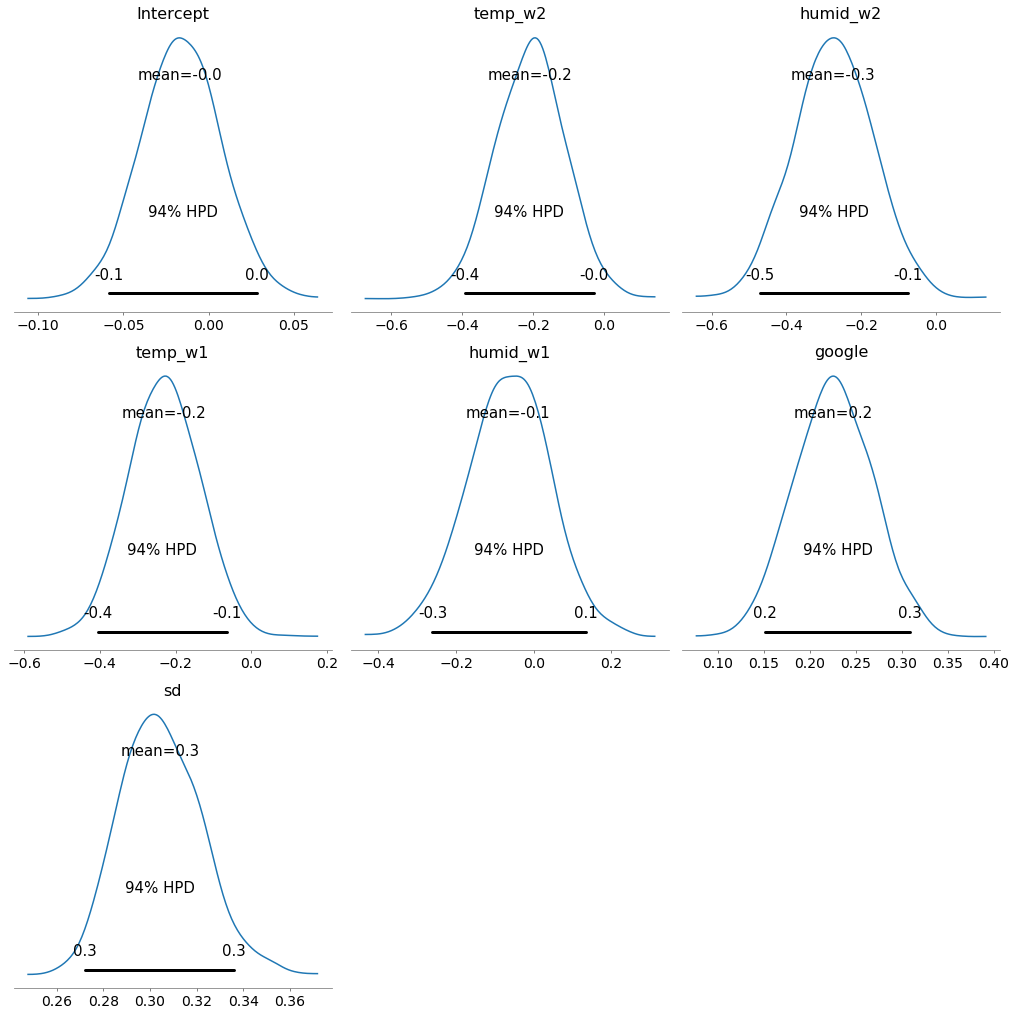

In [107]:
pm.plot_posterior(normal_trace, figsize = (14, 14), text_size=20)
plt.show()

In [108]:
pm.summary(normal_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,-0.016672,0.023180,0.000427,-0.064015,0.027000,3835.701321,1.000779
temp_w2,-0.210110,0.097103,0.001872,-0.403061,-0.024079,3012.343262,0.999887
humid_w2,-0.275258,0.106038,0.002222,-0.471862,-0.058245,2446.038387,1.000001
temp_w1,-0.231443,0.092945,0.001697,-0.404954,-0.050331,2814.506783,1.000646
humid_w1,-0.065935,0.105269,0.002185,-0.282716,0.131944,2049.853351,1.000754
google,0.225355,0.041959,0.000673,0.145895,0.309933,3697.872153,0.999824
sd,0.304492,0.017380,0.000290,0.271444,0.338240,3507.925219,0.999903


In [98]:
model_formula = 'inf_pts = '
for variable in normal_trace.varnames:
    model_formula += ' %0.2f * %s +' % (np.mean(normal_trace[variable]), variable)

' '.join(model_formula.split(' ')[:-1])

'inf_pts =  -0.02 * Intercept + -0.22 * temp_w2 + -0.27 * humid_w2 + -0.22 * temp_w1 + -0.07 * humid_w1 + 0.23 * google + -1.19 * sd_log__ + 0.31 * sd'

In [109]:
# Evalute the MCMC trace and compare to ml models
def evaluate_trace(trace, X_train, X_test, y_train, y_test, model_results):
    
    # Dictionary of all sampled values for each parameter
    var_dict = {}
    for variable in trace.varnames:
        var_dict[variable] = trace[variable]
        
    # Results into a dataframe
    var_weights = pd.DataFrame(var_dict)
    
    # Means for all the weights
    var_means = var_weights.mean(axis=0)
    
    # Create an intercept column
    X_test['Intercept'] = 1
    
    # Align names of the test observations and means
    names = X_test.columns[1:]
    X_test = X_test.loc[:, names]
    var_means = var_means[names]
    
    # Calculate estimate for each test observation using the average weights
    results = pd.DataFrame(index = X_test.index, columns = ['estimate'])

    for row in X_test.iterrows():
        results.loc[row[0], 'estimate'] = np.dot(np.array(var_means), np.array(row[1]))
        
    # Metrics 
    actual = np.array(y_test)
    errors = results['estimate'] - actual
    mae = np.mean(abs(errors))
    rmse = np.sqrt(np.mean(errors ** 2))
    
    print('Model  MAE: {:.4f}\nModel RMSE: {:.4f}'.format(mae, rmse))
    
    # Add the results to the comparison dataframe
    model_results.loc['Bayesian LR', :] = [mae, rmse]
    
    plt.figure(figsize=(12, 8))
    
    # Plot median absolute percentage error of all models
    ax = plt.subplot(1, 2, 1)
    model_results.sort_values('mae', ascending = True).plot.bar(y = 'mae', color = 'r', ax = ax)
    plt.title('Model Mean Absolute Error Comparison'); plt.ylabel('MAE'); 
    plt.tight_layout()
    
    # Plot root mean squared error of all models
    ax = plt.subplot(1, 2, 2)
    model_results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'b', ax = ax)
    plt.title('Model RMSE Comparison'); plt.ylabel('RMSE')
    
    return model_results

Model  MAE: 0.2734
Model RMSE: 0.3273


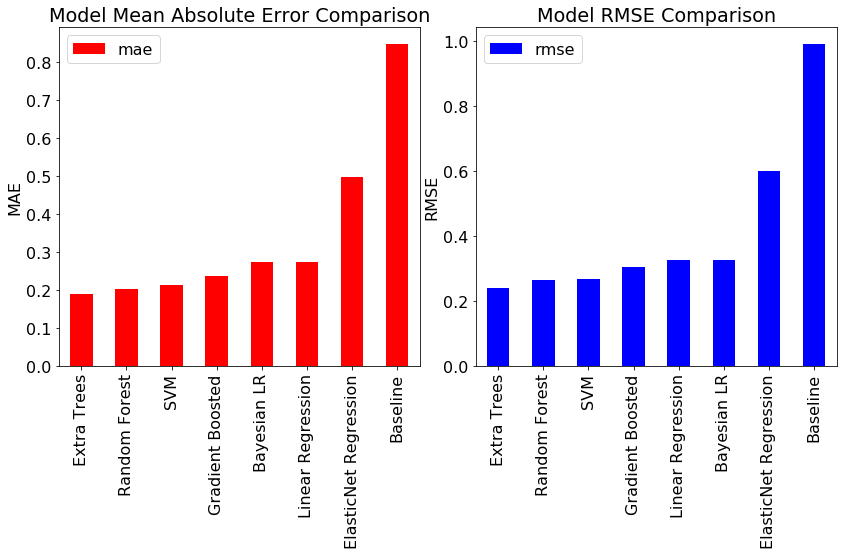

In [100]:
all_model_results = evaluate_trace(normal_trace, X_train, X_test, y_train, y_test, results)

In [89]:
all_model_results.sort_values(by='mae')

,mae,rmse
Extra Trees,0.190917,0.241776
Random Forest,0.203898,0.265387
SVM,0.213961,0.269012
Gradient Boosted,0.237296,0.30428
Bayesian LR,0.273645,0.327369
Linear Regression,0.273938,0.32653
ElasticNet Regression,0.499299,0.598888
Baseline,0.849795,0.991545


In [110]:
print('Bayesian LRはBaselineより{:0.2f}%優れている'.format(
    (100 * abs(all_model_results.loc['Bayesian LR', 'mae'] - all_model_results.loc['Baseline', 'mae'])) / results.loc['Baseline', 'mae']))

Bayesian LRはBaselineより67.83%優れている
